# Predictive maintenance - Water Pump

<Use Case library>

|  |  |
|--|--|
|**Title:** | Predictive maintenance: Water Pump |
|**Author:** | Michal Bezak, Tangent Works|
|**Industry:** | Manufacturing, Infrastructure, Agriculture ... |
|**Area:** | Maintenance, Operations |
|**Type:** | Forecasting, Classification  |

## Description

Predictive maintenance covers variety of areas, including but not limited to:

- prediction of failure,
- root cause analysis,
- failure detection,
- failure type classification,
- recommendation of mitigation or maintenance actions after failure.

To avoid downtimes caused by malfunction of technical equipment, companies follow maintenance schedule to discover and fix potential issues. Nevertheless, with more data (from sensors installed) available there are new possibilities how to make maintenance process better. With AI/ML it is possible to further optimize maintenance schedule.

This has tangible financial implications, imagine two extreme situations:

- Maintenance planned for later than needed - tech. equipment would reach point of failure and cause operations disruptions, every minute of downtime can bring big losses, delays of other parts of the process, not to mention implications to health or lives of people.
- If a company makes maintenance too often or too soon, expenses for time and material spent is higher than situation required, also, should component be replaced completely, capital invested into machine/components is not utilized to its full potential.

We will demonstrate how TIM can support prediction of failure for water pump. List of applications for water pumps is broad, for example they are used in plumbing systems in buildings, agriculture, in fire protection systems, manufacturing, mining, etc. 

The basic principle of pump is to create vacuum thus water (liquid) can be lifted (moved). There are various types of pumps, for instance centrifugal, piston, diaphragm, lobe, piston etc. each has its advantages for specific application.

Pumps consist of multiple elements and, considering their importance, pro-active approach to maintenance is typically required.

In this Use case we will solve following problem: Is water pump going to fail within N cycles?. From ML perspective this can be framed as a binary classification problem.


## Business parameters

|  |  |
|--|--|
|**Business objective:** | Financial: Maximize value of capital, minimize operational costs |
|**Business value:** |  Capital utilization |
|**KPI:** |   |

|  |  |
|--|--|
|**Business objective:** | Operations: Decrease down-times |
|**Business value:** | Higher availability |
|**KPI:** |   |


In [3]:
import logging
import pandas as pd
import plotly as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import json
import datetime

from sklearn.metrics import confusion_matrix, recall_score, precision_score
import scikitplot as skplt

import tim_client

Credentials and logging

(Do not forget to fill in your credentials in the credentials.json file)

In [4]:
with open('credentials.json') as f:
    credentials_json = json.load(f)                     # loading the credentials from credentials.json

TIM_URL = 'https://timws.tangent.works/v4/api'          # URL to which the requests are sent

SAVE_JSON = False                                       # if True - JSON requests and responses are saved to JSON_SAVING_FOLDER
JSON_SAVING_FOLDER = 'logs/'                            # folder where the requests and responses are stored

LOGGING_LEVEL = 'INFO'

In [5]:
level = logging.getLevelName(LOGGING_LEVEL)
logging.basicConfig(level=level, format='[%(levelname)s] %(asctime)s - %(name)s:%(funcName)s:%(lineno)s - %(message)s')
logger = logging.getLogger(__name__)

In [6]:
credentials = tim_client.Credentials(credentials_json['license_key'], credentials_json['email'], credentials_json['password'], tim_url=TIM_URL)
api_client = tim_client.ApiClient(credentials)

api_client.save_json = SAVE_JSON
api_client.json_saving_folder_path = JSON_SAVING_FOLDER

[INFO] 2021-04-06 11:44:43,790 - tim_client.api_client:save_json:66 - Saving JSONs functionality has been disabled
[INFO] 2021-04-06 11:44:43,791 - tim_client.api_client:json_saving_folder_path:75 - JSON destination folder changed to logs


## Dataset

Dataset contains measurement from tens of sensors. There were no specific details shared about sensors.

### Sampling

Raw data files were transformed into time series with hourly sampling rate.

### Data

Structure of CSV file:

| Column name | Description |Type | Availability|
|--|--|--|
| **timestamp** | Timestamp | Timestamp column | |
| **window** | Binary label, denotes whether pump will fail in 2-days window | Target | t-1 |
| **sensor01...49** | Sensor measurements |Predictor | t+1 |

NOTE: some sensory data were cut from original dataset due to too many missing values.

If timestamp is within 2-days of expected failure its value was set to 1.

Different sampling rate and/or window before failure point can be subject of next experiment iterations. Selection of sampling / window length depends on technical capabilities (frequency of data capture), and operational specifics - lead time needed to deploy maintenance team to pump's location etc.

### Data situation

If we want TIM to quantify current condition based on measurement, it means that we want to predict value of target based on predictors values, and so the last record of target must be kept empty (NaN/None) in dataset. TIM will use available predictors to predict given record. This situation will be replicated by TIM to calculate results for all out-of-sample records.

CSV files used in experiments can be downloaded [here](data_water_pump.csv).

### Source

Raw data files were acquired at [Kaggle](https://www.kaggle.com/nphantawee/pump-sensor-data).



In [7]:
data = tim_client.load_dataset_from_csv_file('data_water_pump.csv', sep=',')


In [8]:
timestamp_column = 'timestamp'

target_column = 'window'

In [9]:
data.tail()

timestamp  window  sensor_01  sensor_02  sensor_03   sensor_04  \
871  2018-05-24 20:00:00     1.0  47.683013  51.582753  44.497974  631.689800   
872  2018-05-24 21:00:00     1.0  47.491318  51.545861  43.672596  632.298165   
873  2018-05-24 22:00:00     1.0  47.298900  51.466289  43.373841  631.421673   
874  2018-05-24 23:00:00     1.0  47.167243  51.269527  43.430987  632.194285   
875  2018-05-25 00:00:00     NaN  47.345428  51.516296  42.918345  629.259819   

     sensor_05  sensor_06  sensor_07  sensor_08  ...   sensor_40   sensor_41  \
871  75.843036  13.349126  15.672743  15.173369  ...   66.015621   36.215274   
872  72.739737  13.352139  15.644170  15.200978  ...   55.954859   36.280378   
873  71.947043  13.352140  15.647907  15.193624  ...   66.124127   35.789928   
874  71.643759  13.097753  15.642844  15.125747  ...   65.611976   35.299476   
875  68.617612  13.406791  16.050395  15.510425  ...  222.202623  110.315853   

     sensor_42   sensor_43  sensor_44  sensor_45  sensor_46  sensor_47  \
871  36.072046   43.129337  39.154128  38.956404  42.086227  42.274306   
872  36.006941   39.574649  37.794173  37.548225  39.829282  41.218171   
873  35.772566   42.408851  37.755593  40.137924  46.474730  39.945023   
874  34.830727   41.306420  37.070795  40.639467  43.957369  41.372492   
875  83.333329  105.821569  48.088409  48.032407  70.107152  72.963339   

      sensor_48  sensor_49  
871   90.263312  47.902200  
872   80.955824  48.133682  
873   91.724534  51.234568  
874  129.832180  48.929399  
875  130.311006  58.094384  

[5 rows x 50 columns]

In [10]:
data.shape

(876, 50)

### Visualization

In [12]:
vis_df = data.copy()
vis_df['timestamp'] = pd.to_datetime( vis_df['timestamp'] )
vis_df.set_index('timestamp',inplace=True)

timestamps = [ vis_df.index.min() + i * datetime.timedelta(hours=1) for i in range( int( ( vis_df.index.max() - vis_df.index.min() ).total_seconds()/3600 ) + 1 ) ]

temp_df = pd.DataFrame( {'timestamp': timestamps } )
temp_df.set_index( 'timestamp', inplace=True )

vis_df = temp_df.join( vis_df )
vis_df['timestamp'] = vis_df.index

In [15]:
fig = go.Figure()

fig.add_trace(go.Scatter( x = vis_df['timestamp'],
                          y = vis_df['window'] ) )

fig.update_layout( title='1 = window before failure')

fig.show()

## Engine settings

Parameters that need to be set:

- Prediction horizon (Sample + 1) - because we want to predict the next value only, we frame the problem as evaluation of current situation, thus by setting prediction horizon to 1 will ensure we achieve results needed.
- Back-test length (that defines out-of-sample interval).
- setting *modelQuality* to *Medium* would prevent TIM to use lagged values of target itself which is expected otherwise it would basically leak unknown information; setting *allowOffsets* to False will switch off use of lagged values completely, including predictors (this can potentially reduce quality of models built); bottom line is to one of these settings.

We also ask for additional data from engine to see details of sub-models so we define *extendedOutputConfiguration* parameter as well.

In [16]:
backtest_length = int( data.shape[0] * .3 )    # 30% of data will be used for out-of-sample interval.

backtest_length

262

In [17]:
configuration_backtest = {
    'usage': {                                 
        'predictionTo': { 
            'baseUnit': 'Sample',             
            'offset': 1 
        },        
        'modelQuality': [ {'day':0, 'quality':'Medium' } ],
        'backtestLength': backtest_length     
    },
   # 'allowOffsets': False,                  
    'extendedOutputConfiguration': {
        'returnExtendedImportances': True 
    }
}

## Experiment iteration(s)


Proportion of classes for in-sample interval.

In [18]:
data.iloc[:-backtest_length][target_column].value_counts()   # in-sample

0.0    518
1.0     96
Name: window, dtype: int64

Proportion of classes for out-of-sample interval.

In [19]:
data.iloc[-backtest_length:][target_column].value_counts()   # out-of-sample

0.0    166
1.0     95
Name: window, dtype: int64

In [20]:
backtest = api_client.prediction_build_model_predict(data, configuration_backtest)    
backtest.status  

'FinishedWithWarning'

In [21]:
backtest.result_explanations

[{'index': 1,
  'message': 'Predictor window has a value missing for timestamp 2018-04-18 01:00:00.'},
 {'index': 2,
  'message': 'Predictor sensor_38 contains an outlier or a structural change in its most recent records.'}]

In [22]:
out_of_sample_predictions = backtest.aggregated_predictions[1]['values']              # 1 will point to ouf-of-sample interval

In [23]:
out_of_sample_predictions.rename( columns = {'Prediction':target_column+'_pred'}, inplace=True)

In [24]:
out_of_sample_timestamps = out_of_sample_predictions.index.tolist()

In [25]:
evaluation_data = data.copy()

evaluation_data[ timestamp_column ] = pd.to_datetime(data[ timestamp_column ]).dt.tz_localize('UTC')
evaluation_data = evaluation_data[ evaluation_data[ timestamp_column ].isin( out_of_sample_timestamps ) ]

evaluation_data.set_index( timestamp_column,inplace=True )

evaluation_data = evaluation_data[ [ target_column ] ]

In [26]:
def encode_class( x ):
    if x < .5: return 0
    return 1

In [27]:
evaluation_data = evaluation_data.join( out_of_sample_predictions )

evaluation_data[ target_column+'_pred_p' ] =  evaluation_data[ target_column+'_pred' ]
evaluation_data[ target_column+'_pred' ] =  evaluation_data[ target_column+'_pred' ].apply( encode_class )

evaluation_data.head()

window  window_pred  window_pred_p
timestamp                                                    
2018-05-14 02:00:00+00:00     0.0            0       0.000000
2018-05-14 03:00:00+00:00     0.0            0       0.001837
2018-05-14 04:00:00+00:00     0.0            0       0.001095
2018-05-14 05:00:00+00:00     0.0            0       0.002942
2018-05-14 06:00:00+00:00     0.0            0       0.000000

## Insights - inspecting ML models

Simple and extended importances are available for you to see to what extent each predictor contributes to explanation of variance of target variable.

In [28]:
simple_importances = backtest.predictors_importances['simpleImportances']
simple_importances = sorted(simple_importances, key = lambda i: i['importance'], reverse=True) 

simple_importances = pd.DataFrame.from_dict( simple_importances )

simple_importances

importance predictorName
0        43.44     sensor_28
1        10.73     sensor_33
2         9.06     sensor_12
3         7.33     sensor_13
4         6.02     sensor_26
5         3.83     sensor_35
6         3.63     sensor_36
7         3.38     sensor_34
8         2.97     sensor_49
9         2.89     sensor_30
10        2.72     sensor_32
11        2.16     sensor_01
12        1.75     sensor_04
13        0.08     sensor_11

In [29]:
fig = go.Figure()

fig.add_trace(go.Bar( x = simple_importances['predictorName'],
                      y = simple_importances['importance'] )
             )

fig.update_layout(
        title='Simple importances'
)

fig.show()

In [30]:
extended_importances = backtest.predictors_importances['extendedImportances']
extended_importances = sorted(extended_importances, key = lambda i: i['importance'], reverse=True) 

extended_importances = pd.DataFrame.from_dict( extended_importances )

#extended_importances

In [32]:
fig = go.Figure()

fig.add_trace(go.Bar( x = extended_importances[ extended_importances['time'] == '[1]' ]['termName'],
                      y = extended_importances[ extended_importances['time'] == '[1]' ]['importance'] ) )

fig.update_layout(
        title='Features generated from predictors used by model',
        height = 700
)

fig.show()


## Evaluation of results

Results for out-of-sample interval.

### Accuracy

In [34]:
metrics_accuracy = evaluation_data[ evaluation_data[ target_column+'_pred' ] == evaluation_data[target_column]  ].shape[0] / evaluation_data.shape[0]
metrics_accuracy

0.8656126482213439

### Confusion matrix

In [35]:
TP = evaluation_data[ ( evaluation_data[ target_column+'_pred' ] == 1 ) & ( evaluation_data[ target_column ] == 1 ) ].shape[0]
FP = evaluation_data[ ( evaluation_data[ target_column+'_pred' ] == 1 ) & ( evaluation_data[ target_column ] == 0 ) ].shape[0]
TN = evaluation_data[ ( evaluation_data[ target_column+'_pred' ] == 0 ) & ( evaluation_data[ target_column ] == 0 ) ].shape[0]
FN = evaluation_data[ ( evaluation_data[ target_column+'_pred' ] == 0 ) & ( evaluation_data[ target_column ] == 1 ) ].shape[0]

print('True positive:', TP)
print('False positive:', FP)
print('True negative:', TN)
print('False negative:', FN)

True positive: 88
False positive: 27
True negative: 131
False negative: 7


In [36]:
cm = confusion_matrix( evaluation_data[ target_column ]  , evaluation_data[ target_column+'_pred' ]  )

cm = np.pad(cm, (1, 0), 'constant')
cm[0][2] = 1
cm[2][0] = 1

cm

array([[  0,   0,   1],
       [  0, 131,  27],
       [  1,   7,  88]])

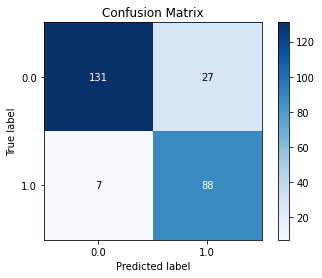

In [39]:
skplt.metrics.plot_confusion_matrix( evaluation_data[target_column], evaluation_data[target_column+'_pred'], normalize=False );

### Precision, Recall, Specificity, F1 score

Precision - proportion of positive data points that are correctly considered as positive, with respect to data points predicted as positive (both correctly and incorrectly).

Recall (true positive rate or Sensitivity) - proportion of positive data points that are correctly considered as positive, with respect to all positive data points.

Specificity (true negative rate) - proportion of negative data points that are correctly considered as negative, with respect to all negative data points.

In [40]:
metrics_precision = precision_score( evaluation_data[ target_column ] , evaluation_data[ target_column+'_pred' ]  )
metrics_precision

0.7652173913043478

In [41]:
metrics_recall = recall_score( evaluation_data[ target_column ] ,  evaluation_data[ target_column+'_pred' ]  )
metrics_recall

0.9263157894736842

In [42]:
metrics_specificity = TN / ( FP + TN )
metrics_specificity

0.8291139240506329

In [43]:
metrics_f1 = 2 * (metrics_precision * metrics_recall) / (metrics_precision + metrics_recall)
metrics_f1

0.8380952380952381

### Cumulative gains & Lift

*Cumulative gain* curve assesses the performance of the model and compares the results with the random pick, it shows the percentage of targets reached when considering a certain percentage of the population.

*Lift* curve indicates how many times more than average (random pick) targets are included in this group. 

In [44]:
evaluation_data = evaluation_data.sort_values( by=[ target_column+'_pred_p' ], ascending=False )

evaluation_data.head()

window  window_pred  window_pred_p
timestamp                                                    
2018-05-18 00:00:00+00:00     1.0            1            1.0
2018-05-17 01:00:00+00:00     0.0            1            1.0
2018-05-17 10:00:00+00:00     1.0            1            1.0
2018-05-16 18:00:00+00:00     0.0            1            1.0
2018-05-17 08:00:00+00:00     1.0            1            1.0

In [45]:
group_size = int( evaluation_data.shape[0] / 100 )
group_size

2

In [46]:
evaluation_data['lift_group'] = 0

group_id = 1

for i in range(100):
    evaluation_data.iloc[ ( i * group_size ) : ( i * group_size + group_size ) ]['lift_group'] = group_id
    group_id += 1

<ipython-input-46-c0fb87c00ddf>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [47]:
rate_total =  evaluation_data[  evaluation_data[ target_column ] == 1 ].shape[0]  / evaluation_data.shape[0]

rate_total

0.37549407114624506

In [48]:
lift_result = dict()

for g in range( 1,100+1 ):
    actual_positive_in_group = evaluation_data[ ( evaluation_data['lift_group'] == g ) & ( evaluation_data[ target_column ] == 1 ) ].shape[0]
    group_population_size = evaluation_data[ ( evaluation_data['lift_group'] == g ) ].shape[0]

    lift_result[g] = { 'model': None, 'baseline': None }
    lift_result[g]['model'] =  actual_positive_in_group / group_population_size / rate_total
    lift_result[g]['baseline'] =  rate_total /  100


In [49]:
lift_result_df = pd.DataFrame.from_dict( lift_result, orient='index')

lift_result_df.tail()

model  baseline
96     0.0  0.003755
97     0.0  0.003755
98     0.0  0.003755
99     0.0  0.003755
100    0.0  0.003755

In [50]:
lift_result_df = lift_result_df.cumsum()

lift_result_df.tail()

model  baseline
96   126.5  0.360474
97   126.5  0.364229
98   126.5  0.367984
99   126.5  0.371739
100  126.5  0.375494

In [51]:
fig = go.Figure()

x_values = lift_result_df.index / 100

y_values_model = lift_result_df['model'] / lift_result_df['model'].iloc[-1]
y_values_baseline = lift_result_df['baseline'] / lift_result_df['baseline'].iloc[-1]

fig.add_trace( go.Scatter( x = x_values , y = y_values_model, name = 'Model' )  )
fig.add_trace( go.Scatter( x = x_values , y = y_values_baseline, name = 'Baseline', line = dict(color='red',  dash='dot')  ) )

fig.update_layout( height = 700, width = 700, title = 'Cumulative gains chart', xaxis_title = '% of samples', yaxis_title = 'Gain' )                           

fig.show()

In [52]:
fig = go.Figure()

x_values = lift_result_df.index / 100

y_values_model = lift_result_df['model'] / lift_result_df['model'].iloc[-1]
y_values_baseline = lift_result_df['baseline'] / lift_result_df['baseline'].iloc[-1]

fig.add_trace( go.Scatter( x = x_values , y = y_values_model / y_values_baseline, name = 'Lift' )  )
fig.add_trace( go.Scatter( x = x_values , y = y_values_baseline / y_values_baseline, name = 'Baseline', line = dict(color='red',  dash='dot')  )  )

fig.update_layout( height = 700, width = 700, title = 'Lift chart', xaxis_title = '% of samples', yaxis_title = 'Lift' )                           

fig.show()

## Summary

We demonstrated how TIM can be used for classification of timestamps in prediction maintenance scenario to recognize 2-days window prior to failure.

With default settings (without any advanced adjustments of math settings), for out-of-sample interval, *true positive rate* is 92%.